# Neural Nets with Keras

In this notebook you will learn how to implement neural networks using the Keras API. We will use TensorFlow's own implementation, *tf.keras*, which comes bundled with TensorFlow.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/tf2_course/blob/master/01_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Don't hesitate to look at the documentation at [keras.io](https://keras.io/). All the code examples should work fine with tf.keras, the only difference is how to import Keras:

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow.keras.layers import Dense
output_layer = Dense(10)

# or:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

In this notebook, we will not use any TensorFlow-specific code, so everything you see would run just the same way on [keras-team](https://github.com/keras-team/keras) or any other Python implementation of the Keras API (except for the imports).

## Imports

In [23]:
%matplotlib inline
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

In [25]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib 3.3.4
numpy 1.19.4
pandas 1.1.5
sklearn 0.24.0
tensorflow 2.5.0
tensorflow.keras 2.5.0


In [26]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – TensorFlow Playground

Visit the [TensorFlow Playground](http://playground.tensorflow.org).
* **Layers and patterns**: try training the default neural network by clicking the "Run" button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns). In general, the more layers, the more complex the patterns can be.
* **Activation function**: try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster, but this time the boundaries are linear. This is due to the shape of the ReLU function.
* **Local minima**: modify the network architecture to have just one hidden layer with three neurons. Train it multiple times (to reset the network weights, just add and remove a neuron). Notice that the training time varies a lot, and sometimes it even gets stuck in a local minimum.
* **Too small**: now remove one neuron to keep just 2. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.
* **Large enough**: next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck in local minima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.
* **Deep net and vanishing gradients**: now change the dataset to be the spiral (bottom right dataset under "DATA"). Change the network architecture to have 4 hidden layers with 8 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the "vanishing gradients" problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.
* **More**: go ahead and play with the other parameters to get a feel of what they do. In fact, after this course you should definitely play with this UI for at least one hour, it will grow your intuitions about neural networks significantly.

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Image classification with tf.keras

### Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [99]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [28]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented by a uint8 (byte) from 0 to 255:

In [29]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  44, 127,
        182, 185, 161, 120,  55,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 198, 251, 255,
        251, 249, 247, 255, 252, 214, 100,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   0, 233, 252, 237, 239,
        234, 237, 235, 237, 237, 254, 227,   0,   0,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,  16, 210, 225, 215, 175,
        217, 216, 193, 196, 226, 221, 209,  50,   0,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   2,   0,   0, 199, 229, 232, 230, 245, 204,
        219, 253, 245, 207, 194, 223, 231, 236, 235,   0,   0,   3,   0,
          0,   0],
       [  

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

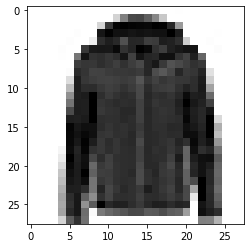

In [30]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [31]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [32]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [33]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [12]:
X_valid.shape

(5000, 28, 28)

In [13]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

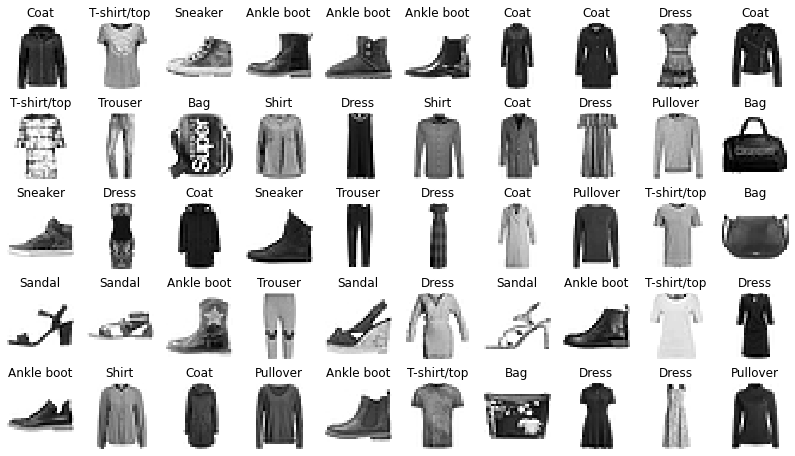

In [34]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

This dataset has the same structure as the famous MNIST dataset (which you can load using `keras.datasets.mnist.load_data()`), except the images represent fashion items rather than handwritten digits, and it is much more challenging. A simple linear model can reach 92% accuracy on MNIST, but only 83% on fashion MNIST.

### Build a classification neural network with Keras

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))

In [16]:
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense

In [18]:
layers = [Flatten(input_shape=[28, 28]), Dense(300, activation="relu"), Dense(100, activation="relu"), Dense(10, activation="softmax")]

In [19]:
model = keras.models.Sequential(layers=layers)

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

**Warning**: you will need `pydot` and `graphviz` to use `plot_model()`.

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


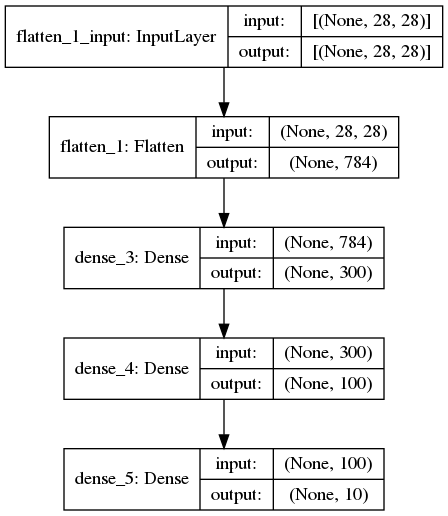

In [16]:
keras.utils.plot_model(model, to_file="fig.png", show_shapes=True)

In [17]:

model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with a learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [18]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 3.0290 - accuracy: 0.6881 - val_loss: 0.6841 - val_accuracy: 0.7520
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6165 - accuracy: 0.7778 - val_loss: 0.5688 - val_accuracy: 0.8040
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5281 - accuracy: 0.8091 - val_loss: 0.5400 - val_accuracy: 0.8154
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4806 - accuracy: 0.8246 - val_loss: 0.5293 - val_accuracy: 0.8226
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4496 - accuracy: 0.8343 - val_loss: 0.4674 - val_accuracy: 0.8374
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4259 - accuracy: 0.8429 - val_loss: 0.5104 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4090 - accuracy: 0.8471 - val_loss: 0.4562 - val_accuracy:

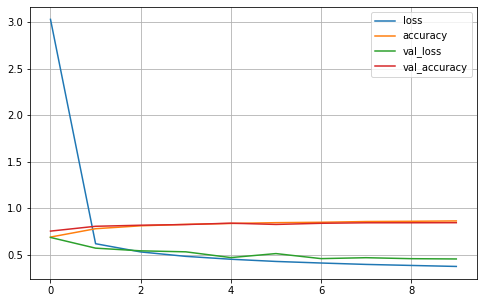

In [19]:
plt = pd.DataFrame(history.history).plot(figsize=(8, 5), grid=True)

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3659 - accuracy: 0.8647 - val_loss: 0.4336 - val_accuracy: 0.8508
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3589 - accuracy: 0.8670 - val_loss: 0.4415 - val_accuracy: 0.8492
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3499 - accuracy: 0.8712 - val_loss: 0.4455 - val_accuracy: 0.8382
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3454 - accuracy: 0.8707 - val_loss: 0.4343 - val_accuracy: 0.8444
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3391 - accuracy: 0.8732 - val_loss: 0.4249 - val_accuracy: 0.8534
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3327 - accuracy: 0.8757 - val_loss: 0.4297 - val_accuracy: 0.8528
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3289 - accuracy: 0.8778 - val_loss: 0.4218 - val_accuracy:

### 2.8)
call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [28]:
loss, acc = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5075 - accuracy: 0.8227


### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [64]:
X_new = X_test[:10,:, :]
X_new.shape

(10, 28, 28)

In [98]:
y_new = model.predict(X_new)
print(y_new.round(2))

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.81 0.   0.01 0.   0.18 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.11 0.   0.05 0.03 0.01 0.   0.81 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.   0.98 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]]


In [99]:
y_new.argmax(axis=1)

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.11)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [100]:
y_new.max(axis=1)

array([0.99535525, 0.80887127, 1.        , 1.        , 0.8076138 ,
       1.        , 0.9788657 , 0.9999441 , 1.        , 0.9999993 ],
      dtype=float32)

### 2.12)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [112]:
k = 3
k_new = np.argsort(-y_new)[:, :k]
k_new

array([[9, 7, 5],
       [2, 6, 4],
       [1, 3, 6],
       [1, 3, 2],
       [6, 0, 2],
       [1, 3, 6],
       [4, 2, 6],
       [6, 4, 2],
       [5, 7, 6],
       [7, 5, 9]])

In [116]:
row_indices = np.tile(range(len(k_new)), [k, 1]).T

y_new[row_indices, k_new].round(2)

array([[1.  , 0.  , 0.  ],
       [0.81, 0.18, 0.01],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.81, 0.11, 0.05],
       [1.  , 0.  , 0.  ],
       [0.98, 0.02, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ]], dtype=float32)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 - Solution

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [74]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [76]:
model.layers

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


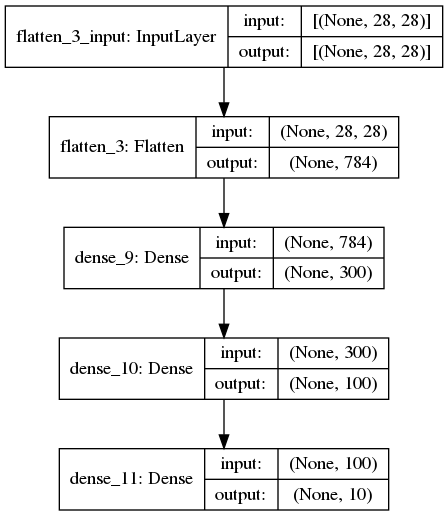

In [78]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

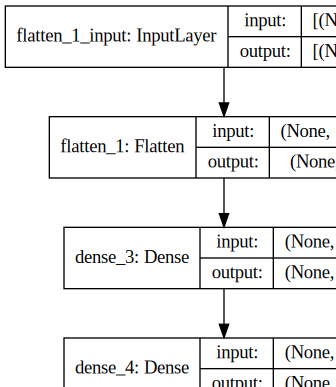

In [35]:
from IPython.display import SVG
SVG(keras.utils.model_to_dot(model, show_shapes=True).create(prog="dot", format="svg"))

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [81]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [83]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3567 - accuracy: 0.8662 - val_loss: 0.4250 - val_accuracy: 0.8530
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3483 - accuracy: 0.8693 - val_loss: 0.4505 - val_accuracy: 0.8468
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3407 - accuracy: 0.8729 - val_loss: 0.4424 - val_accuracy: 0.8530
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3377 - accuracy: 0.8739 - val_loss: 0.4346 - val_accuracy: 0.8546
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3302 - accuracy: 0.8762 - val_loss: 0.4316 - val_accuracy: 0.8564
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3252 - accuracy: 0.8779 - val_loss: 0.4373 - val_accuracy: 0.8490
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3194 - accuracy: 0.8792 - val_loss: 0.4291 - val_accuracy:

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [36]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)


In [37]:
plot_learning_curves(history)

NameError: name 'history' is not defined

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [88]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3040 - accuracy: 0.8854 - val_loss: 0.4351 - val_accuracy: 0.8538
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2994 - accuracy: 0.8875 - val_loss: 0.4234 - val_accuracy: 0.8608
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2957 - accuracy: 0.8883 - val_loss: 0.4324 - val_accuracy: 0.8600
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2942 - accuracy: 0.8881 - val_loss: 0.4392 - val_accuracy: 0.8546
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2897 - accuracy: 0.8901 - val_loss: 0.4292 - val_accuracy: 0.8612
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2872 - accuracy: 0.8912 - val_loss: 0.4239 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2835 - accuracy: 0.8930 - val_loss: 0.4354 - val_accuracy:

### 2.8)
Call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [89]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4426 - accuracy: 0.8538


[0.4425669014453888, 0.8537999987602234]

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [90]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.81, 0.  , 0.01, 0.  , 0.18, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.11, 0.  , 0.05, 0.03, 0.01, 0.  , 0.81, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [23]:
y_pred = y_proba.argmax(axis=1)
y_pred

NameError: name 'y_proba' is not defined

### 2.11)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [24]:
y_proba.max(axis=1).round(2)

NameError: name 'y_proba' is not defined

### 2.12)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [95]:
k = 3
top_k = np.argsort(-y_proba, axis=1)[:, :k]
top_k

array([[9, 7, 5],
       [2, 6, 4],
       [1, 3, 6],
       [1, 3, 2],
       [6, 0, 2],
       [1, 3, 6],
       [4, 2, 6],
       [6, 4, 2],
       [5, 7, 6],
       [7, 5, 9]])

In [108]:
row_indices = np.tile(np.arange(len(top_k)), [k, 1]).T
print(row_indices)
print(top_k)
y_proba[row_indices, top_k].round(2)

[[0 0 0]
 [1 1 1]
 [2 2 2]
 [3 3 3]
 [4 4 4]
 [5 5 5]
 [6 6 6]
 [7 7 7]
 [8 8 8]
 [9 9 9]]
[[9 7 5]
 [2 6 4]
 [1 3 6]
 [1 3 2]
 [6 0 2]
 [1 3 6]
 [4 2 6]
 [6 4 2]
 [5 7 6]
 [7 5 9]]


array([[1.  , 0.  , 0.  ],
       [0.81, 0.18, 0.01],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.81, 0.11, 0.05],
       [1.  , 0.  , 0.  ],
       [0.98, 0.02, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ]], dtype=float32)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 3 – Scale the features

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

**Tips**:
* For each feature (pixel intensity), you must subtract the `mean()` of that feature (across all instances, so use `axis=0`) and divide by its standard deviation (`std()`, again `axis=0`). Alternatively, you can use Scikit-Learn's `StandardScaler`.
* Make sure you compute the means and standard deviations on the training set, and use these statistics to scale the training set, the validation set and the test set (you should not fit the validation set or the test set, and computing the means and standard deviations counts as "fitting").

In [97]:
pixel_mean = X_train.mean(axis=0)
pixel_std = X_train.std(axis=0)

scaled_x_train = (X_train - pixel_mean)/pixel_std
scaled_x_valid = (X_valid - pixel_mean)/pixel_std
scaled_x_test = (X_test - pixel_mean)/pixel_std
print(scaled_x_train.shape)

(55000, 28, 28)


In [98]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
x_scaled_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28* 28)).reshape(-1, 28, 28)
x_scaled_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28* 28)).reshape(-1, 28, 28)
x_scaled_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28* 28)).reshape(-1, 28, 28)

x_scaled_valid.shape

(5000, 28, 28)

### 3.2)
Plot the learning curves. Do they look better than earlier?

In [27]:
from tensorflow import keras

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])
model.compile(optimizer=keras.optimizers.SGD(1e-3), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history = model.fit(x_scaled_train, y_train, validation_data=(x_scaled_valid, y_valid), epochs=20)

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9518 - accuracy: 0.6983 - val_loss: 0.6356 - val_accuracy: 0.7914
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5823 - accuracy: 0.8005 - val_loss: 0.5289 - val_accuracy: 0.8182
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5053 - accuracy: 0.8235 - val_loss: 0.4798 - val_accuracy: 0.8348
Epoch 4/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4643 - accuracy: 0.8375 - val_loss: 0.4513 - val_accuracy: 0.8454
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4376 - accuracy: 0.8460 - val_loss: 0.4329 - val_accuracy: 0.8504
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4182 - accuracy: 0.8528 - val_loss: 0.4195 - val_accuracy: 0.8550
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4029 - accuracy: 0.8580 - val_loss: 0.4095 - val_accuracy:

In [28]:
model.evaluate(x_scaled_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3842 - accuracy: 0.8639


[0.38424578309059143, 0.8639000058174133]

AttributeError: 'AxesSubplot' object has no attribute 'gca'

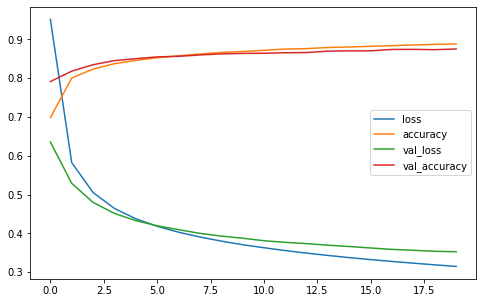

In [29]:
plot_learning_curves(history)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 3 – Solution

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

In [100]:
pixel_means = X_train.mean(axis = 0)
pixel_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9103 - accuracy: 0.7026 - val_loss: 0.6097 - val_accuracy: 0.7946
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5724 - accuracy: 0.7993 - val_loss: 0.5146 - val_accuracy: 0.8228
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5040 - accuracy: 0.8218 - val_loss: 0.4709 - val_accuracy: 0.8410
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4668 - accuracy: 0.8348 - val_loss: 0.4441 - val_accuracy: 0.8498
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4417 - accuracy: 0.8439 - val_loss: 0.4279 - val_accuracy: 0.8524
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4234 - accuracy: 0.8496 - val_loss: 0.4144 - val_accuracy: 0.8606
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4086 - accuracy: 0.8555 - val_loss: 0.4050 - val_accuracy:

In [70]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3935 - accuracy: 0.8614


[0.3935014009475708, 0.8614000082015991]

### 3.2)
Plot the learning curves. Do they look better than earlier?

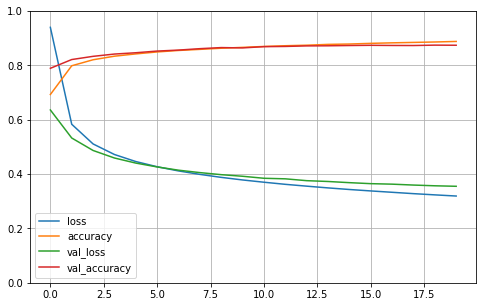

In [71]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 4 – Use Callbacks

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [74]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])

In [80]:
root_logdir = os.path.join(os.curdir, "logs")
log_dir = os.path.join(root_logdir, f"run_{time.time()}")

In [81]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir),
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
]

### 4.2)
The Jupyter plugin for tensorboard was loaded at the beginning of this notebook (`%load_ext tensorboard`), so you can now simply start it by using the `%tensorboard` magic command. Explore the various tabs available, in particular the SCALARS tab to view learning curves, the GRAPHS tab to view the computation graph, and the PROFILE tab which is very useful to identify bottlenecks if you run into performance issues.

In [82]:
%tensorboard --logdir {root_logdir}

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [83]:
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Epoch 1/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9767 - accuracy: 0.6823 - val_loss: 0.6598 - val_accuracy: 0.7798
Epoch 2/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6036 - accuracy: 0.7908 - val_loss: 0.5533 - val_accuracy: 0.8108
Epoch 3/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5261 - accuracy: 0.8140 - val_loss: 0.5051 - val_accuracy: 0.8280
Epoch 4/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4839 - accuracy: 0.8285 - val_loss: 0.4749 - val_accuracy: 0.8378
Epoch 5/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4559 - accuracy: 0.8387 - val_loss: 0.4548 - val_accuracy: 0.8456
Epoch 6/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4352 - accuracy: 0.8448 - val_loss: 0.4390 - val_accuracy: 0.8506
Epoch 7/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4188 - accuracy: 0.8503 - val_loss: 0.4283 - val_accuracy:

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

In [84]:
model = keras.models.load_model("my_mnist_model.h5")

In [85]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3303 - accuracy: 0.8844


[0.33031517267227173, 0.8844000101089478]

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 4 – Solution

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [86]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])

In [87]:
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Epoch 1/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9715 - accuracy: 0.6851 - val_loss: 0.6424 - val_accuracy: 0.7850
Epoch 2/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5962 - accuracy: 0.7954 - val_loss: 0.5318 - val_accuracy: 0.8172
Epoch 3/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5178 - accuracy: 0.8189 - val_loss: 0.4833 - val_accuracy: 0.8352
Epoch 4/50
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4757 - accuracy: 0.8325 - val_loss: 0.4548 - val_accuracy: 0.8436
Epoch 5/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4479 - accuracy: 0.8423 - val_loss: 0.4356 - val_accuracy: 0.8484
Epoch 6/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4275 - accuracy: 0.8486 - val_loss: 0.4218 - val_accuracy: 0.8508
Epoch 7/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4114 - accuracy: 0.8543 - val_loss: 0.4097 - val_accuracy:

### 4.2)
Done

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [88]:
model = keras.models.load_model("my_mnist_model.h5")

In [89]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 2ms/step - loss: 0.3202 - accuracy: 0.8846


[0.3201519250869751, 0.8845999836921692]

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 5 – A neural net for regression

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [140]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [141]:
print(housing.data.shape)
print(housing.target.shape)


(20640, 8)
(20640,)


In [142]:
from sklearn.model_selection import train_test_split

x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target,  random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, random_state=42)

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [143]:
len(x_train), len(x_valid), len(x_test)
x_train.shape

(11610, 8)

In [144]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_valid = scaler.transform(x_valid)
scaled_x_test = scaler.transform(x_test)

In [51]:
model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=x_train.shape[1:]),
        keras.layers.Dense(1)
    ])

model.compile(optimizer=keras.optimizers.SGD(1e-3), loss="mean_squared_error", metrics=['accuracy'])

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [52]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(scaled_x_train, y_train,
                    validation_data=(scaled_x_valid, y_valid),
                    epochs=100,
                    callbacks=callbacks
                   )

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 2.1292 - accuracy: 0.0022 - val_loss: 0.9862 - val_accuracy: 0.0044
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.0029 - val_loss: 0.6908 - val_accuracy: 0.0044
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6314 - accuracy: 0.0029 - val_loss: 0.6383 - val_accuracy: 0.0044
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5995 - accuracy: 0.0029 - val_loss: 0.6192 - val_accuracy: 0.0044
Epoch 5/100
363/363 [==============================] - 1s 1ms/step - loss: 0.5716 - accuracy: 0.0029 - val_loss: 0.6005 - val_accuracy: 0.0044
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5472 - accuracy: 0.0029 - val_loss: 0.5350 - val_accuracy: 0.0044
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5252 - accuracy: 0.0029 - val_loss: 0.5207 - val_accuracy: 0.0044

In [89]:
model.evaluate(scaled_x_test, y_test)

162/162 [==============================] - 0s 900us/step - loss: 0.3701 - accuracy: 0.0021


[0.3700743615627289, 0.0021317829377949238]

In [90]:
model.predict(scaled_x_test)

array([[0.7836219],
       [1.8637273],
       [3.9677672],
       ...,
       [1.3876834],
       [2.2761502],
       [3.8805757]], dtype=float32)

AttributeError: 'AxesSubplot' object has no attribute 'gca'

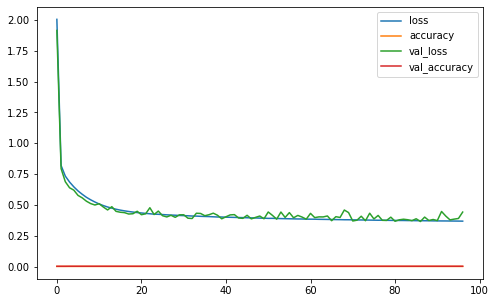

In [91]:
plot_learning_curves(history)

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

**Tips**:
* Since you are predicting a single value per district (the median house price), there should only be one neuron in the output layer.
* Usually for regression tasks you don't want to use any activation function in the output layer (in some cases you may want to use `"relu"` or `"softplus"` if you want to constrain the predicted values to be positive, or `"sigmoid"` or `"tanh"` if you want to constrain the predicted values to 0-1 or -1-1).
* A good loss function for regression is generally the `"mean_squared_error"` (aka `"mse"`). When there are many outliers in your dataset, you may prefer to use the `"mean_absolute_error"` (aka `"mae"`), which is a bit less precise but less sensitive to outliers.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 5 – Solution

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [92]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [93]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [94]:
housing.data.shape

(20640, 8)

In [95]:
housing.target.shape

(20640,)

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [96]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [97]:
len(X_train), len(X_valid), len(X_test)

(11610, 3870, 5160)

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

ValueError: Found array with dim 3. StandardScaler expected <= 2.

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

In [99]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [100]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid), epochs=100,
                    callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 2.0422 - val_loss: 1.7454
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.8249 - val_loss: 1.0757
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7224 - val_loss: 0.8179
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6748 - val_loss: 0.6962
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6375 - val_loss: 0.6203
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6067 - val_loss: 0.5883
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5810 - val_loss: 0.5567
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5592 - val_loss: 0.5330
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5409 - val_loss: 0.5178
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5249 - val_lo

In [101]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 998us/step - loss: 0.3602


0.36022472381591797

In [102]:
model.predict(X_test_scaled)

array([[0.5864237],
       [1.6617186],
       [3.9484308],
       ...,
       [1.4599285],
       [2.725314 ],
       [4.0439577]], dtype=float32)

AttributeError: 'AxesSubplot' object has no attribute 'gca'

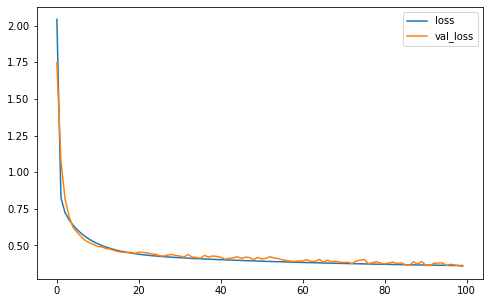

In [103]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 6 – Hyperparameter search

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [104]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
            keras.layers.Dense(30, activation="relu", input_shape=x_train.shape[1:]),
            keras.layers.Dense(1)
        ])
    model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate))
    history = model.fit(scaled_x_train, y_train,
                        validation_data=(scaled_x_valid, y_valid), epochs=100)
    histories.append(history)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 4.3485 - val_loss: 10.7517
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 3.2805 - val_loss: 10.7998
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 2.5585 - val_loss: 9.9305
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 2.0533 - val_loss: 9.0351
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 1.6953 - val_loss: 7.8826
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 1.4389 - val_loss: 6.6276
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 1.2531 - val_loss: 5.4576
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 1.1165 - val_loss: 4.5644
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 1.0165 - val_loss: 3.7620
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.9425 - val_

363/363 [==============================] - 0s 1ms/step - loss: 0.4432 - val_loss: 0.4194
Epoch 62/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4416 - val_loss: 0.4179
Epoch 63/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4401 - val_loss: 0.4174
Epoch 64/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4386 - val_loss: 0.4166
Epoch 65/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4372 - val_loss: 0.4160
Epoch 66/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4358 - val_loss: 0.4156
Epoch 67/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4344 - val_loss: 0.4146
Epoch 68/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4331 - val_loss: 0.4134
Epoch 69/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4318 - val_loss: 0.4119
Epoch 70/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4307 - val_loss: 

363/363 [==============================] - 0s 1ms/step - loss: 0.3754 - val_loss: 0.3715
Epoch 22/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3741 - val_loss: 0.3769
Epoch 23/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3726 - val_loss: 0.3866
Epoch 24/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3713 - val_loss: 0.3576
Epoch 25/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3698 - val_loss: 0.4018
Epoch 26/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3690 - val_loss: 0.3862
Epoch 27/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3676 - val_loss: 0.3555
Epoch 28/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3665 - val_loss: 0.3499
Epoch 29/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3654 - val_loss: 0.3804
Epoch 30/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3646 - val_loss: 

363/363 [==============================] - 0s 1ms/step - loss: 0.3153 - val_loss: 0.3039
Epoch 82/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3149 - val_loss: 0.3197
Epoch 83/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3116 - val_loss: 1.2214
Epoch 84/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3168 - val_loss: 0.3009
Epoch 85/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3135 - val_loss: 0.3075
Epoch 86/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3132 - val_loss: 0.3136
Epoch 87/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3128 - val_loss: 0.5162
Epoch 88/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3122 - val_loss: 0.3010
Epoch 89/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3096 - val_loss: 0.3015
Epoch 90/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3100 - val_loss: 

Learning rate: 0.0001
Learning rate: 0.0003
Learning rate: 0.001
Learning rate: 0.003
Learning rate: 0.03


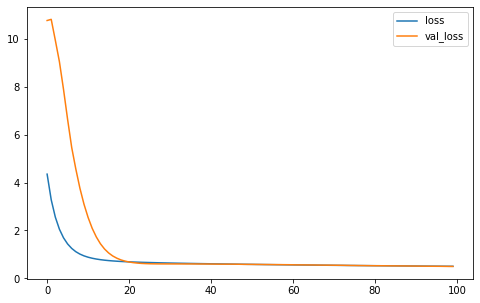

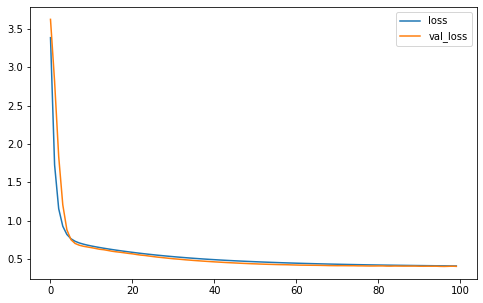

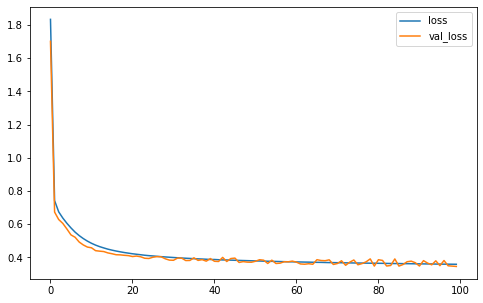

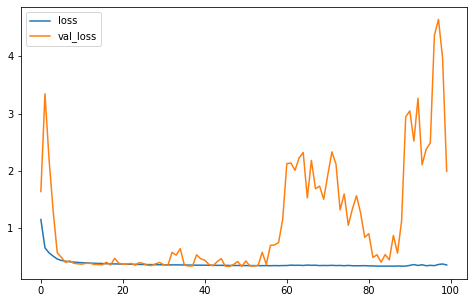

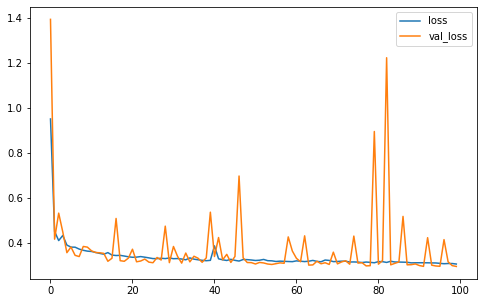

In [111]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [126]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model = keras.models.Sequential([
            keras.layers.Dense(n_neurons, activation="relu", input_shape=x_train.shape[1:]),
        ])
    options = {"input_shape": x_train.shape[1:]}
    for layer_idx in range(n_hidden+1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1), **options)
    model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate))
    return model
    
                  

In [127]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [128]:
callbacks = keras.callbacks.EarlyStopping(patience=10)
keras_reg.fit(scaled_x_train, y_train,
              validation_data=(scaled_x_valid, y_valid),
              epochs=100,
              callbacks=callbacks
             )

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 1.5565 - val_loss: 2.2341
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7090 - val_loss: 0.9193
Epoch 3/100
363/363 [==============================] - 1s 1ms/step - loss: 0.6470 - val_loss: 0.7671
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6051 - val_loss: 0.6239
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5706 - val_loss: 0.5696
Epoch 6/100
363/363 [==============================] - 1s 1ms/step - loss: 0.5410 - val_loss: 0.5950
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5161 - val_loss: 0.5017
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4933 - val_loss: 0.5050
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4740 - val_loss: 0.4717
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4571 - val_lo

In [129]:
keras_reg.predict(scaled_x_test)

array([0.7291461, 1.6420994, 4.3142567, ..., 1.5066047, 2.3839037,
       4.0741887], dtype=float32)

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [39]:
from scipy.stats import reciprocal

In [40]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist()
}

In [133]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Tips**:
* create a `param_distribs` dictionary where each key is the name of a hyperparameter you want to fine-tune (e.g., `"n_hidden"`), and each value is the list of values you want to explore (e.g., `[0, 1, 2, 3]`), or a Scipy distribution from `scipy.stats`.
* You can use the reciprocal distribution for the learning rate (e.g, `reciprocal(3e-3, 3e-2)`).
* Create a `RandomizedSearchCV`, passing the `KerasRegressor` and the `param_distribs` to its constructor, as well as the number of iterations (`n_iter`), and the number of cross-validation folds (`cv`). If you are short on time, you can set `n_iter=10` and `cv=3`. You may also want to set `verbose=2`.
* Finally, call the `RandomizedSearchCV`'s `fit()` method on the training set. Once again you can pass it `n_epochs`, `validation_data` and `callbacks` if you want to.
* The best parameters found will be available in the `best_params_` attribute, the best score will be in `best_score_`, and the best model will be in `best_estimator_`.

In [134]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 2.6271 - val_loss: 1.9552
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.0618 - val_loss: 1.0041
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8496 - val_loss: 0.7652
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7476 - val_loss: 0.6874
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6907 - val_loss: 0.6456
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6528 - val_loss: 0.6169
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6240 - val_loss: 0.5845
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5995 - val_loss: 0.5643
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5774 - val_loss: 0.5338
Epoch 10/100
242/242 [========

Epoch 77/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3266 - val_loss: 0.3847
Epoch 78/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3262 - val_loss: 0.3661
Epoch 79/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3257 - val_loss: 0.3906
Epoch 80/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3249 - val_loss: 0.3758
Epoch 81/100
121/121 [==============================] - 0s 956us/step - loss: 0.3329
[CV] END learning_rate=0.0005541096586143834, n_hidden=3, n_neurons=76; total time=  34.1s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7920 - val_loss: 0.5028
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4345 - val_loss: 0.3668
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3856 - val_loss: 0.3549
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3748 - val_loss: 0.3584
Epoch 5/100


242/242 [==============================] - 0s 2ms/step - loss: 0.3958 - val_loss: 0.4040
Epoch 24/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3921 - val_loss: 0.4008
Epoch 25/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3884 - val_loss: 0.4076
Epoch 26/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3851 - val_loss: 0.4139
Epoch 27/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3820 - val_loss: 0.4100
Epoch 28/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3793 - val_loss: 0.4093
Epoch 29/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3765 - val_loss: 0.4147
Epoch 30/100
121/121 [==============================] - 0s 936us/step - loss: 0.3882
[CV] END learning_rate=0.0005439509362218602, n_hidden=2, n_neurons=89; total time=  13.4s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 2.6109 - val_loss: 10.4021
Epoch 2/100
242/242 [

242/242 [==============================] - 0s 2ms/step - loss: 0.3802 - val_loss: 0.4241
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3589 - val_loss: 0.4693
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3475 - val_loss: 0.4701
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3415 - val_loss: 0.5043
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3336 - val_loss: 0.5902
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3245 - val_loss: 0.6349
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3194 - val_loss: 0.5037
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3157 - val_loss: 0.5417
Epoch 11/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3123 - val_loss: 0.6213
Epoch 12/100
121/121 [==============================] - 0s 1ms/step - loss: 0.3817
[CV] END learning_

Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4498 - val_loss: 0.3594
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3624 - val_loss: 1.6509
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3831 - val_loss: 2.3102
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3675 - val_loss: 0.7164
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3529 - val_loss: 0.5389
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3415 - val_loss: 0.3628
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3325 - val_loss: 0.3538
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3267 - val_loss: 0.3512
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3256 - val_loss: 0.3179
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3169 - val_

Epoch 63/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4266 - val_loss: 0.4169
Epoch 64/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4250 - val_loss: 0.4188
Epoch 65/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4237 - val_loss: 0.4203
Epoch 66/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4221 - val_loss: 0.4190
Epoch 67/100
121/121 [==============================] - 0s 793us/step - loss: 0.4391
[CV] END learning_rate=0.00046906849246775224, n_hidden=3, n_neurons=15; total time=  23.4s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 4.1651 - val_loss: 2.5175
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.6963 - val_loss: 1.4711
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0379 - val_loss: 1.3466
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9042 - val_loss: 1.0388
Epoch 5/100

Epoch 75/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3796 - val_loss: 0.3764
Epoch 76/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3787 - val_loss: 0.3754
Epoch 77/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3781 - val_loss: 0.3739
Epoch 78/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3773 - val_loss: 0.3725
Epoch 79/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3766 - val_loss: 0.3712
Epoch 80/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3759 - val_loss: 0.3699
Epoch 81/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3749 - val_loss: 0.3683
Epoch 82/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3744 - val_loss: 0.3673
Epoch 83/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3738 - val_loss: 0.3660
Epoch 84/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3729

Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4359 - val_loss: 0.4064
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4341 - val_loss: 0.4056
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4321 - val_loss: 0.4044
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4303 - val_loss: 0.4024
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4283 - val_loss: 0.4019
Epoch 59/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4268 - val_loss: 0.3997
Epoch 60/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4247 - val_loss: 0.4002
Epoch 61/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4236 - val_loss: 0.3979
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4219 - val_loss: 0.3967
Epoch 63/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4202

Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3072 - val_loss: 0.6017
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3058 - val_loss: 0.4609
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3048 - val_loss: 0.3456
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3042 - val_loss: 0.4660
Epoch 25/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3048 - val_loss: 0.4603
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3034 - val_loss: 0.5397
Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3047 - val_loss: 0.6381
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3024 - val_loss: 0.6597
Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2983 - val_loss: 0.8892
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2979

242/242 [==============================] - 0s 1ms/step - loss: 0.2736 - val_loss: 0.3631
Epoch 54/100
121/121 [==============================] - 0s 898us/step - loss: 0.2900
[CV] END learning_rate=0.00595956439123707, n_hidden=2, n_neurons=83; total time=  20.8s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.9470 - val_loss: 1.8545
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7936 - val_loss: 0.6969
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6050 - val_loss: 0.5773
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5488 - val_loss: 0.5226
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5111 - val_loss: 0.4691
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4804 - val_loss: 0.4392
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4543 - val_loss: 0.4207
Epoch 8/100
242/242 [=========

Epoch 78/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2873 - val_loss: 0.2930
Epoch 79/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2862 - val_loss: 0.3261
Epoch 80/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2862 - val_loss: 0.3197
Epoch 81/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2850 - val_loss: 0.2951
Epoch 82/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2847 - val_loss: 0.3005
Epoch 83/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2844 - val_loss: 0.3362
Epoch 84/100
121/121 [==============================] - 0s 931us/step - loss: 0.3220
[CV] END learning_rate=0.0011629527254531631, n_hidden=3, n_neurons=59; total time=  31.8s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 2.0052 - val_loss: 10.8931
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8394 - val_loss: 5.1718
Epoch 3/1

/home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [-0.37689015 -0.33596123 -0.37415626 -0.32819587 -0.32539744 -0.30128208
 -0.39654656         nan -0.32010644 -0.33761498]
  category=UserWarning


363/363 [==============================] - 1s 1ms/step - loss: 0.6010 - val_loss: 0.5602
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3929 - val_loss: 6.2807
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4144 - val_loss: 0.7368
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3610 - val_loss: 0.3438
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3481 - val_loss: 0.3317
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3391 - val_loss: 0.3431
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3338 - val_loss: 0.3032
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3298 - val_loss: 0.3220
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3220 - val_loss: 0.3286
Epoch 10/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3178 - val_loss: 0.3549
E

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc72fd22080>,
                   param_distributions={'learning_rate': [0.001093640555838534,
                                                          0.0010879504391265807,
                                                          0.00128787776772482,
                                                          0.014723507756426541,
                                                          0.012129835865667727,
                                                          0.005271960349435263,
                                                          0.0036277402907536004,
                                                          0.008793876479576274,
                                                          0.010222471344742483,
                                                          0.0...
                                                          0.00035998390

In [135]:
rnd_search_cv.best_params_

{'n_neurons': 90, 'n_hidden': 1, 'learning_rate': 0.012948368333068732}

In [137]:
rnd_search_cv.best_score_

-0.3012820780277252

In [136]:
rnd_search_cv.best_estimator_

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [138]:
model = rnd_search_cv.best_estimator_.model

In [141]:
model.evaluate(scaled_x_test, y_test)

162/162 [==============================] - 0s 869us/step - loss: 0.2876


0.2876044511795044

In [142]:
model.save("my_fine_tuned_housing_model.h5")

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

**Tip**: while a randomized search is nice and simple, there are more powerful (but complex) options available out there for hyperparameter search, for example:
* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Hyperas](https://github.com/maxpumperla/hyperas)
* [Sklearn-Deap](https://github.com/rsteca/sklearn-deap)
* [Scikit-Optimize](https://scikit-optimize.github.io/)
* [Spearmint](https://github.com/JasperSnoek/spearmint)
* [PyMC3](https://docs.pymc.io/)
* [GPFlow](https://gpflow.readthedocs.io/)
* [Yelp/MOE](https://github.com/Yelp/MOE)
* Commercial services such as: [Google Cloud ML Engine](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning), [Arimo](https://arimo.com/) or [Oscar](http://oscar.calldesk.ai/)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 6 – Solution

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [ ]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_valid_scaled, y_valid), epochs=100,
                        callbacks=callbacks)
    histories.append(history)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 4.2762 - val_loss: 3.5676
Epoch 2/100
363/363 [==============================] - 1s 1ms/step - loss: 3.2434 - val_loss: 3.0457
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 2.5457 - val_loss: 2.7941
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 2.0564 - val_loss: 2.5906
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 1.7035 - val_loss: 2.4049
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 1.4445 - val_loss: 2.2068
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 1.2529 - val_loss: 1.9905
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 1.1106 - val_loss: 1.7864
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 1.0048 - val_loss: 1.5956
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.9259 - val_lo

In [ ]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    options = {"input_shape": X_train.shape[1:]}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
keras_reg.predict(X_test_scaled)

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Warning**: due to a change in Scikit-Learn, the following code breaks if we don't use `.tolist()` and `.rvs(1000).tolist()`. See [Keras issue #13586](https://github.com/keras-team/keras/issues/13586) for more details.

In [ ]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

In [ ]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
rnd_search_cv.best_estimator_

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [ ]:
rnd_search_cv.score(X_test_scaled, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

In [ ]:
model.save("my_fine_tuned_housing_model.h5")

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 7 – The functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer, as shown on the following diagram:

<img src="images/wide_and_deep_net.png" title="Wide and deep net" width=300 />

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

**Tips**:
* You need to create a `keras.layers.Input` layer to represent the inputs. Don't forget to specify the input `shape`.
* Create the `Dense` layers, and connect them by using them like functions. For example, `hidden1 = keras.layers.Dense(30, activation="relu")(input)` and `hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)`
* Use the `keras.layers.concatenate()` function to concatenate the input layer and the second hidden layer's output.
* Create a `keras.models.Model` and specify its `inputs` and `outputs` (e.g., `inputs=[input]`).
* Then use this model just like a `Sequential` model: you need to compile it, display its summary, train it, evaluate it and use it to make predictions.

In [103]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [104]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [105]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3))

In [106]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 28, 30)       870         input_8[0][0]                    
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 28, 30)       930         dense_47[0][0]                   
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 28, 58)       0           input_8[0][0]                    
                                                                 dense_48[0][0]             

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

**When should you use the Subclassing API?**
* Both the Sequential API and the Functional API are declarative: you first declare the list of layers you need and how they are connected, and only then can you feed your model with actual data. The models that these APIs build are just static graphs of layers. This has many advantages (easy inspection, debugging, saving, loading, sharing, etc.), and they cover the vast majority of use cases, but if you need to build a very dynamic model (e.g., with loops or conditional branching), or if you want to experiment with new ideas using an imperative programming style, then the Subclassing API is for you. You can pretty much do any computation you want in the `call()` method, possibly with loops and conditions, using Keras layers of even low-level TensorFlow operations.
* However, this extra flexibility comes at the cost of less transparency. Since the model is defined within the `call()` method, Keras cannot fully inspect it. All it sees is the list of model attributes (which include the layers you define in the constructor), so when you display the model summary you just see a list of unconnected layers. Consequently, you cannot save or load the model without writing extra code. So this API is best used only when you really need the extra flexibility.

In [112]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)
 
    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [121]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3), metrics=['accuracy'])

In [122]:
history = model.fit(scaled_x_train, y_train, validation_data=(scaled_x_valid, y_valid), epochs=10)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 3.5628 - accuracy: 0.0976 - val_loss: 3.4231 - val_accuracy: 0.1104
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 3.5544 - accuracy: 0.0978 - val_loss: 3.4243 - val_accuracy: 0.1099
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 3.5445 - accuracy: 0.0978 - val_loss: 3.4177 - val_accuracy: 0.1106
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 3.5371 - accuracy: 0.0978 - val_loss: 3.4045 - val_accuracy: 0.1105
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 3.5274 - accuracy: 0.0978 - val_loss: 3.3925 - val_accuracy: 0.1101
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 3.5181 - accuracy: 0.0979 - val_loss: 3.4322 - val_accuracy: 0.1107
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 3.5139 - accuracy: 0.0979 - val_loss: 3.3730 - val_accuracy:

In [123]:
model.summary()

Model: "my_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             multiple                  870       
_________________________________________________________________
dense_54 (Dense)             multiple                  930       
_________________________________________________________________
dense_55 (Dense)             multiple                  59        
Total params: 1,859
Trainable params: 1,859
Non-trainable params: 0
_________________________________________________________________


In [124]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 3.5319 - accuracy: 0.0985


[3.5318844318389893, 0.09847858548164368]

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the following diagram. Use the functional API to build, train and evaluate this model.

**Tips**:
* You need to create two `keras.layers.Input` (`input_A` and `input_B`)
* Build the model using the functional API, as above, but when you build the `keras.models.Model`, remember to set `inputs=[input_A, input_B]`
* When calling `fit()`, `evaluate()` and  `predict()`, instead of passing `X_train_scaled`, pass `(X_train_scaled_A, X_train_scaled_B)` (two NumPy arrays containing only the appropriate features copied from `X_train_scaled`).

<img src="images/multiple_inputs.png" title="Multiple inputs" width=300 />

In [125]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [126]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [133]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3))
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_59 (Dense)                (None, 30)           210         input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_60 (Dense)                (None, 30)           930         dense_59[0][0]                   
___________________________________________________________________________________________

In [138]:
X_train_scaled_A = scaled_x_train[:, :5]
X_train_scaled_B = scaled_x_train[:, 2:]
X_valid_scaled_A = scaled_x_valid[:, :5]
X_valid_scaled_B = scaled_x_valid[:, 2:]
X_test_scaled_A = scaled_x_test[:, :5]
X_test_scaled_B = scaled_x_test[:, 2:]

In [139]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=10,
                   validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))

Epoch 1/10


ValueError: in user code:

    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/user/Desktop/ml_workbook/venv/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:270 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 1 is incompatible with layer model_10: expected shape=(None, 6), found shape=(None, 26, 28)


In [ ]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

In [ ]:
model.predict([X_test_scaled_A, X_test_scaled_b])

### 7.4)
Build the multi-input and multi-output neural net represented in the following diagram.

<img src="images/multiple_inputs_and_outputs.png" title="Multiple inputs and outputs" width=400 />

**Why?**

There are many use cases in which having multiple outputs can be useful:
* Your task may require multiple outputs, for example, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object's center, as well as its width and height) and a classification task.
* Similarly, you may have multiple independent tasks to perform based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks.
* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model's ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (as shown in the diagram) to ensure that that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

**Tips**:
* Building the model is pretty straightforward using the functional API. Just make sure you specify both outputs when creating the `keras.models.Model`, for example `outputs=[output, aux_output]`.
* Each output has its own loss function. In this scenario, they will be identical, so you can either specify `loss="mse"` (this loss will apply to both outputs) or `loss=["mse", "mse"]`, which does the same thing.
* The final loss used to train the whole network is just a weighted sum of all loss functions. In this scenario, you want most to give a much smaller weight to the auxiliary output, so when compiling the model, you must specify `loss_weights=[0.9, 0.1]`.
* When calling `fit()` or `evaluate()`, you need to pass the labels for all outputs. In this scenario the labels will be the same for the main output and for the auxiliary output, so make sure to pass `(y_train, y_train)` instead of `y_train`.
* The `predict()` method will return both the main output and the auxiliary output.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 7 – Solution

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

In [ ]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [ ]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

In [ ]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)

    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3))

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the diagram. Use the functional API to build, train and evaluate this model.

In [155]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [156]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [157]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [163]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3), metrics=['accuracy'])

In [164]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_62 (Dense)                (None, 30)           210         input_14[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 30)           930         dense_62[0][0]                   
___________________________________________________________________________________________

In [165]:
X_train_scaled_A = scaled_x_train[:, :5]
X_train_scaled_B = scaled_x_train[:, 2:]
X_valid_scaled_A = scaled_x_valid[:, :5]
X_valid_scaled_B = scaled_x_valid[:, 2:]
X_test_scaled_A = scaled_x_test[:, :5]
X_test_scaled_B = scaled_x_test[:, 2:]

X_train_scaled_A.shape

(11610, 5)

In [166]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4865 - accuracy: 0.0027 - val_loss: 0.4713 - val_accuracy: 0.0044
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4781 - accuracy: 0.0027 - val_loss: 0.4585 - val_accuracy: 0.0044
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.4715 - accuracy: 0.0026 - val_loss: 0.4598 - val_accuracy: 0.0044
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4654 - accuracy: 0.0026 - val_loss: 0.4470 - val_accuracy: 0.0044
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.4602 - accuracy: 0.0025 - val_loss: 0.4362 - val_accuracy: 0.0044
Epoch 6/10
363/363 [==============================] - 1s 1ms/step - loss: 0.4557 - accuracy: 0.0025 - val_loss: 0.4351 - val_accuracy: 0.0044
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4513 - accuracy: 0.0025 - val_loss: 0.4243 - val_accuracy: 0.0044
Epoch 

In [167]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.0019


[0.43704310059547424, 0.0019379844889044762]

In [168]:
model.predict([X_test_scaled_A, X_test_scaled_B])

array([[0.5696397],
       [1.8193519],
       [3.2142048],
       ...,
       [1.3899257],
       [2.7428498],
       [3.6383178]], dtype=float32)

### 7.4)
Build the multi-input and multi-output neural net represented in the diagram.

In [178]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [179]:
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [180]:
model.compile(loss="mean_squared_error", loss_weights=[0.9, 0.1],
              optimizer=keras.optimizers.SGD(1e-3))

In [181]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 30)           210         input_18[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 30)           930         dense_69[0][0]                   
___________________________________________________________________________________________

In [182]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.3293 - dense_71_loss: 2.0890 - dense_72_loss: 4.4927 - val_loss: 2.6498 - val_dense_71_loss: 2.4168 - val_dense_72_loss: 4.7466
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 1.0119 - dense_71_loss: 0.8205 - dense_72_loss: 2.7352 - val_loss: 1.0990 - val_dense_71_loss: 0.7358 - val_dense_72_loss: 4.3683
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8127 - dense_71_loss: 0.6829 - dense_72_loss: 1.9816 - val_loss: 1.0494 - val_dense_71_loss: 0.7037 - val_dense_72_loss: 4.1608
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7356 - dense_71_loss: 0.6355 - dense_72_loss: 1.6356 - val_loss: 0.9282 - val_dense_71_loss: 0.6025 - val_dense_72_loss: 3.8593
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6901 - dense_71_loss: 0.6037 - dense_72_loss: 1.4682 - val_loss: 0.8526 - val_dense_71_loss: 0.5901 - val_de

In [183]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.5530 - dense_71_loss: 0.4888 - dense_72_loss: 1.1309


[0.5529879331588745, 0.48877283930778503, 1.1309247016906738]

In [184]:
y_pred, y_pred_aux = model.predict([X_test_scaled_A, X_test_scaled_B])

In [185]:
y_pred

array([[0.49171078],
       [1.4873998 ],
       [2.7668839 ],
       ...,
       [1.2305    ],
       [2.6463099 ],
       [3.5370464 ]], dtype=float32)

In [186]:
y_pred_aux

array([[1.2542224],
       [1.5753441],
       [2.509365 ],
       ...,
       [1.6290584],
       [1.6279595],
       [2.2249596]], dtype=float32)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 8 – Deep Nets

Let's go back to Fashion MNIST and build deep nets to tackle it. We need to load it, split it and scale it.

In [187]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [188]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

In [189]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3), metrics=['accuracy'])

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 2.3020 - accuracy: 0.1410 - val_loss: 2.3014 - val_accuracy: 0.2004
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.3004 - accuracy: 0.2081 - val_loss: 2.2991 - val_accuracy: 0.2328
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2973 - accuracy: 0.2481 - val_loss: 2.2948 - val_accuracy: 0.2484
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2916 - accuracy: 0.2523 - val_loss: 2.2870 - val_accuracy: 0.2608
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2798 - accuracy: 0.2820 - val_loss: 2.2689 - val_accuracy: 0.2616
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2504 - accuracy: 0.2466 - val_loss: 2.2229 - val_accuracy: 0.1994
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.1654 - accuracy: 0.2169 - val_loss: 2.0707 - val_accuracy:

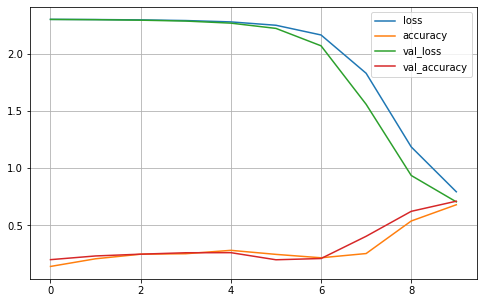

In [190]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [191]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7297 - accuracy: 0.7023


[0.7297466397285461, 0.7023000121116638]

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

In [201]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3), metrics=['accuracy'])


Epoch 1/10
1719/1719 [==============================] - 16s 7ms/step - loss: 1.9661 - accuracy: 0.3511 - val_loss: 1.0570 - val_accuracy: 0.6506
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 1.1065 - accuracy: 0.6233 - val_loss: 0.7843 - val_accuracy: 0.7230
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9367 - accuracy: 0.6755 - val_loss: 0.6744 - val_accuracy: 0.7566
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8684 - accuracy: 0.6952 - val_loss: 0.6288 - val_accuracy: 0.7748
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8144 - accuracy: 0.7145 - val_loss: 0.5945 - val_accuracy: 0.7834
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7712 - accuracy: 0.7308 - val_loss: 0.5700 - val_accuracy: 0.7934
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7374 - accuracy: 0.7427 - val_loss: 0.5407 - val_ac

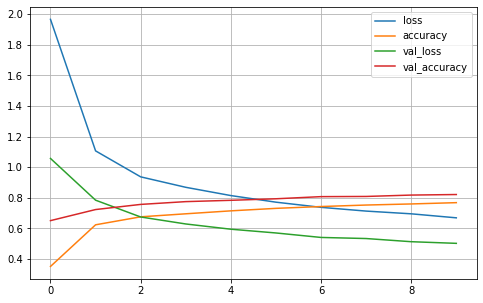

In [202]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [203]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5349 - accuracy: 0.8089


[0.5348609685897827, 0.808899998664856]

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

In [204]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3), metrics=['accuracy'])

Epoch 1/10
1719/1719 [==============================] - 16s 7ms/step - loss: 1.9637 - accuracy: 0.3208 - val_loss: 1.2929 - val_accuracy: 0.5872
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 1.2367 - accuracy: 0.5915 - val_loss: 0.8541 - val_accuracy: 0.6990
Epoch 3/10
1719/1719 [==============================] - 13s 7ms/step - loss: 1.0024 - accuracy: 0.6577 - val_loss: 0.7069 - val_accuracy: 0.7498
Epoch 4/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8928 - accuracy: 0.6940 - val_loss: 0.6318 - val_accuracy: 0.7736
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.8145 - accuracy: 0.7187 - val_loss: 0.5896 - val_accuracy: 0.7922
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7692 - accuracy: 0.7350 - val_loss: 0.5549 - val_accuracy: 0.8058
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7272 - accuracy: 0.7476 - val_loss: 0.5343 - val_ac

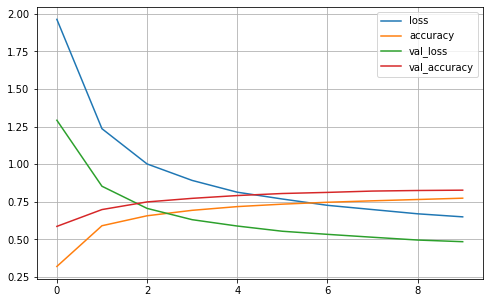

In [205]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [ ]:
model.evaluate(X_test_scaled, y_test)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

In [208]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
             kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3), metrics=['accuracy'])

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6486 - accuracy: 0.7725 - val_loss: 0.4894 - val_accuracy: 0.8258
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4564 - accuracy: 0.8357 - val_loss: 0.4322 - val_accuracy: 0.8494
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4053 - accuracy: 0.8539 - val_loss: 0.4042 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3743 - accuracy: 0.8653 - val_loss: 0.3898 - val_accuracy: 0.8590
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3507 - accuracy: 0.8738 - val_loss: 0.3739 - val_accuracy: 0.8648
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3325 - accuracy: 0.8805 - val_loss: 0.3667 - val_accuracy: 0.8676
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3171 - accuracy: 0.8859 - val_loss: 0.3602 - val_accuracy:

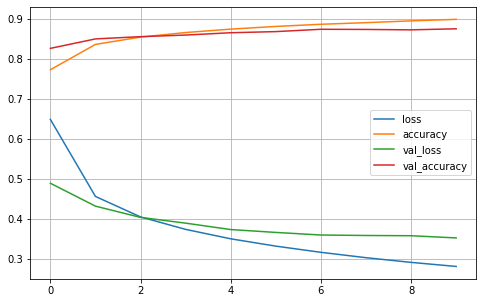

In [209]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [211]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3903 - accuracy: 0.8644


[0.39033427834510803, 0.8644000291824341]

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

**Warning**: you should not use regular Dropout, as it breaks the self-normalizing property of the SELU activation function. Instead, use AlphaDropout, which is designed to work with SELU.

In [212]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
             kernel_initializer="lecun_normal"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3), metrics=['accuracy'])

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.1992 - accuracy: 0.6028 - val_loss: 0.7447 - val_accuracy: 0.8178
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6719 - accuracy: 0.7869 - val_loss: 0.7002 - val_accuracy: 0.8442
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5572 - accuracy: 0.8228 - val_loss: 0.6386 - val_accuracy: 0.8564
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4933 - accuracy: 0.8408 - val_loss: 0.5982 - val_accuracy: 0.8654
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4519 - accuracy: 0.8536 - val_loss: 0.6078 - val_accuracy: 0.8690
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4229 - accuracy: 0.8616 - val_loss: 0.6039 - val_accuracy: 0.8726
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3989 - accuracy: 0.8677 - val_loss: 0.5653 - val_accuracy:

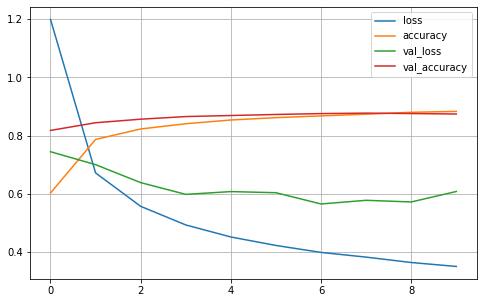

In [213]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [214]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.6690 - accuracy: 0.8642


[0.6690029501914978, 0.8641999959945679]

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 8 – Solution

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 2.3022 - accuracy: 0.1082 - val_loss: 2.3017 - val_accuracy: 0.1588
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.3011 - accuracy: 0.1687 - val_loss: 2.3006 - val_accuracy: 0.1496
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2999 - accuracy: 0.2059 - val_loss: 2.2990 - val_accuracy: 0.2462
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2976 - accuracy: 0.2572 - val_loss: 2.2960 - val_accuracy: 0.3136
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2934 - accuracy: 0.3033 - val_loss: 2.2901 - val_accuracy: 0.3532
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2851 - accuracy: 0.3337 - val_loss: 2.2783 - val_accuracy: 0.3146
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 2.2680 - accuracy: 0.2892 - val_loss: 2.2538 - val_accuracy:

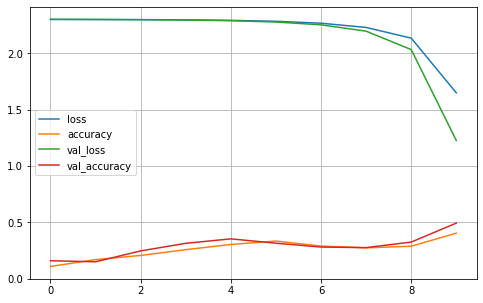

In [215]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

Epoch 1/10
1719/1719 [==============================] - 16s 7ms/step - loss: 1.9589 - accuracy: 0.3435 - val_loss: 1.1154 - val_accuracy: 0.6338
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 1.1341 - accuracy: 0.6055 - val_loss: 0.8229 - val_accuracy: 0.7164
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9678 - accuracy: 0.6652 - val_loss: 0.7030 - val_accuracy: 0.7566
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8782 - accuracy: 0.6969 - val_loss: 0.6577 - val_accuracy: 0.7740
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8305 - accuracy: 0.7123 - val_loss: 0.6264 - val_accuracy: 0.7828
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7850 - accuracy: 0.7267 - val_loss: 0.5811 - val_accuracy: 0.7984
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7503 - accuracy: 0.7407 - val_loss: 0.5586 - val_ac

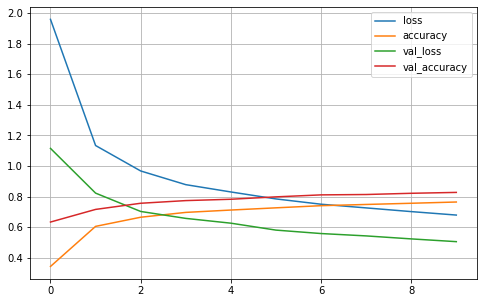

In [216]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [217]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_284 (Dense)            (None, 100)               78500     
_________________________________________________________________
batch_normalization_120 (Bat (None, 100)               400       
_________________________________________________________________
dense_285 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_121 (Bat (None, 100)               400       
_________________________________________________________________
dense_286 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_122 (Bat (None, 100)             

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

Epoch 1/10
1719/1719 [==============================] - 15s 7ms/step - loss: 2.0546 - accuracy: 0.2756 - val_loss: 1.3855 - val_accuracy: 0.5188
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.2754 - accuracy: 0.5651 - val_loss: 0.8752 - val_accuracy: 0.6918
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.0112 - accuracy: 0.6577 - val_loss: 0.7269 - val_accuracy: 0.7418
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.9006 - accuracy: 0.6936 - val_loss: 0.6597 - val_accuracy: 0.7600
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8353 - accuracy: 0.7115 - val_loss: 0.6265 - val_accuracy: 0.7754
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7894 - accuracy: 0.7270 - val_loss: 0.5882 - val_accuracy: 0.7906
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7421 - accuracy: 0.7437 - val_loss: 0.5626 - val_ac

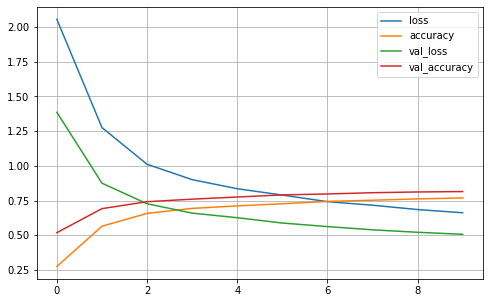

In [218]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6596 - accuracy: 0.7697 - val_loss: 0.4852 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4477 - accuracy: 0.8390 - val_loss: 0.4288 - val_accuracy: 0.8436
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3988 - accuracy: 0.8574 - val_loss: 0.4030 - val_accuracy: 0.8564
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3686 - accuracy: 0.8676 - val_loss: 0.3955 - val_accuracy: 0.8578
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3476 - accuracy: 0.8761 - val_loss: 0.3770 - val_accuracy: 0.8654
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3298 - accuracy: 0.8826 - val_loss: 0.3670 - val_accuracy: 0.8698
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3158 - accuracy: 0.8876 - val_loss: 0.3622 - val_accuracy:

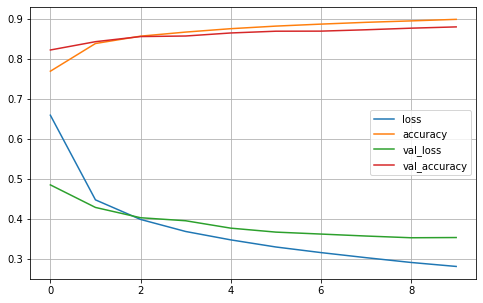

In [219]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2711 - accuracy: 0.9027 - val_loss: 0.3461 - val_accuracy: 0.8794
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2626 - accuracy: 0.9056 - val_loss: 0.3472 - val_accuracy: 0.8754
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2535 - accuracy: 0.9087 - val_loss: 0.3443 - val_accuracy: 0.8784
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2454 - accuracy: 0.9113 - val_loss: 0.3459 - val_accuracy: 0.8806
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2377 - accuracy: 0.9138 - val_loss: 0.3529 - val_accuracy: 0.8760
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2301 - accuracy: 0.9170 - val_loss: 0.3457 - val_accuracy: 0.8772
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2234 - accuracy: 0.9197 - val_loss: 0.3526 - val_accuracy:

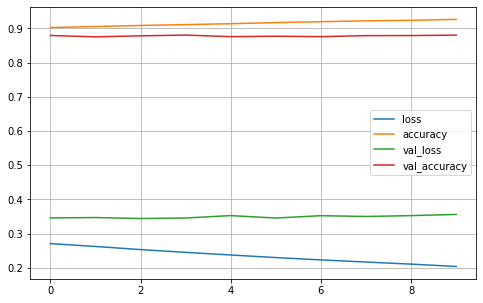

In [220]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 1.1787 - accuracy: 0.6017 - val_loss: 0.7923 - val_accuracy: 0.8080
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6654 - accuracy: 0.7867 - val_loss: 0.6957 - val_accuracy: 0.8374
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5550 - accuracy: 0.8216 - val_loss: 0.6455 - val_accuracy: 0.8526
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4966 - accuracy: 0.8392 - val_loss: 0.6338 - val_accuracy: 0.8610
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4570 - accuracy: 0.8513 - val_loss: 0.6241 - val_accuracy: 0.8616
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4312 - accuracy: 0.8608 - val_loss: 0.5782 - val_accuracy: 0.8680
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4091 - accuracy: 0.8649 - val_loss: 0.5881 - val_accuracy:

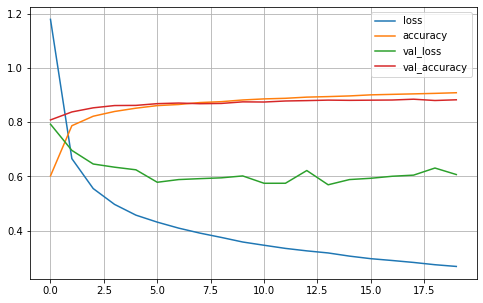

In [221]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)